# 📸Shallow Focus With Computation
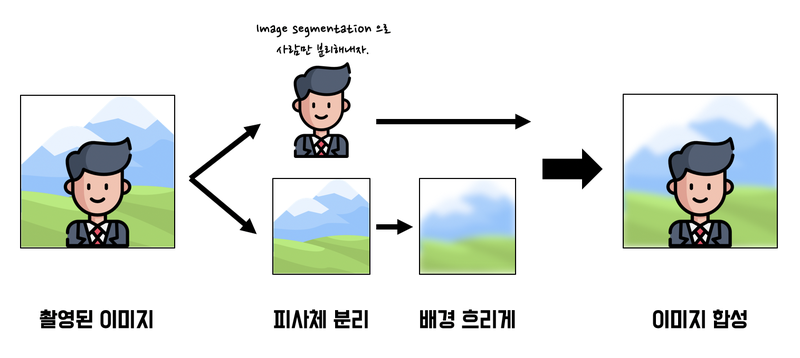
<div style="text-align: right"> 출처: LMS EXP 8</div>

- 흔히 아웃포커스를 위해 DSLR을 구매하던 날들이 있을 것이다. 이번 과제에서는 `누끼따기`와 `아웃포커싱`을 DeepLabV3+ 모델을 이용해 진행해 볼 것이다.
- 또한 이 과정에서 발생하는 작은 오류를 개선할 수 있는 방법으로 Google Brain에 기재된 `struct2depth`기법을 살펴보고자 한다.

목차
1. [MODEL 적용](#1.-MODEL-적용)
2. [배경 준비](#2.-배경준비)
3. [합성](#3.-합성)
4. [[Part2] 문제점 식별](#[Part2]-문제점-식별)
5. [[Part3] 문제 해결을 위한 제언](#[Part3]-문제점-해결)

In [18]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

import os

# 1. MODEL 적용

## 1-1. Model 불러오기

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 1-2. Model 적용해서 Segmentation 확보하기
- 나의 사진과 고양이 사진 불러오기

In [66]:
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
addr_dict = {'me.jpg' : 'person', 'cat.png' : 'cat'}

img_paths = []
for img in addr_dict.keys():
    img_paths.append(os.path.join(img_dir, img))
    
img_origs = []
for img_path in img_paths :
    img_origs.append(cv2.imread(img_path))
    print(img_origs[-1].shape)

(633, 475, 3)
(394, 596, 3)


- 배경합성을 위해 배경사진을 불러오고 나의 사진 resize하기

In [67]:
img_path = os.path.join(img_dir, 'gameofthrone.jpg')
back_ground = cv2.imread(img_path)

In [67]:
img_orig = img_origs[0]
img_orig_resized = cv2.resize(img_orig, (int( (img_orig.shape[1]/img_orig.shape[0]) * back_ground.shape[0] ), back_ground.shape[0] ) )
img_origs.append(img_orig_resized)

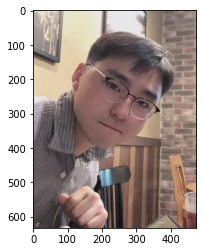

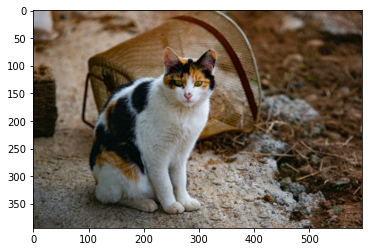

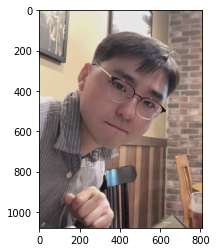

In [75]:
for img_orig in img_origs :
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

- 모델 적용하기

In [68]:
img_segs = []
for img_orig in img_origs :
    img_segs.append(MODEL.run(img_orig))
#     img_resized, seg_map = MODEL.run(img_orig)
#     print (img_orig.shape, img_resized.shape, seg_map.max())
    print(img_orig.shape, img_segs[-1][0].shape, img_segs[-1][1].max())

(633, 475, 3) (513, 384, 3) 15
(394, 596, 3) (339, 513, 3) 8
(1080, 810, 3) (513, 384, 3) 15


In [5]:
# LABEL_NAMES = [
#     'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#     'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
#     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
# ]
# len(LABEL_NAMES)

21

- MODEL결과값(resized image, segment map) 해석
  - seg_map은 검출된 픽셀의 class를 의미한다

- sement map을 활용하기 위해 mask 만들기
  - applyColorMap() 함수로 색을 적용

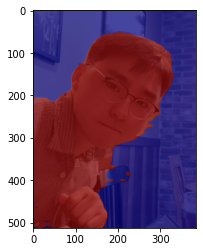

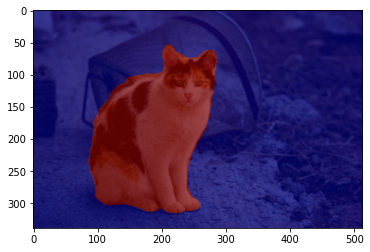

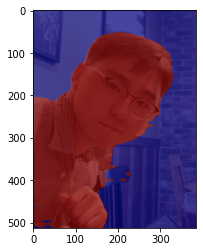

In [70]:
img_shows = []
for img_seg in img_segs :
    img_resized = img_seg[0]
    img_shows.append(img_resized.copy())

#sementic segmentation을 적용한 후 mask를 만든다
seg_maps = []
for img_seg, img_class in zip(img_segs,['person', 'cat', 'person']) :
    seg_map = img_seg[1]
    if img_class == 'person':
        seg_maps.append(np.where(seg_map == 15, 15, 0))
    elif img_class == 'cat':
        seg_maps.append(np.where(seg_map == 8, 8, 0))

img_masks = []
color_masks = []
for seg_map in seg_maps :
    img_mask = (seg_map * (255/seg_map.max())).astype(np.uint8)
    img_masks.append(img_mask)
    color_masks.append(cv2.applyColorMap(img_mask, cv2.COLORMAP_JET))

#mask를 이용하여 이미지를 출력한다 
for idx, img_mask in enumerate(zip(img_shows, color_masks)) :
    img_show, color_mask = img_mask
    img_shows[idx] = cv2.addWeighted(img_show, 0.3, color_mask, 0.7, 0.0)

for img_show in img_shows :
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

# img_show = img_resized.copy()
# seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출

# img_mask = seg_map * (255/seg_map.max()) # 255 normalization
# img_mask = img_mask.astype(np.uint8)
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

- 세그먼테이션 결과를 원래 크기로 복원하기
    - 보간interpolation: 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법 [참고자료](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html)
    - cv2.INTER_NEAREST 가능 / cv2.INTER_LINEAR 정확

결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

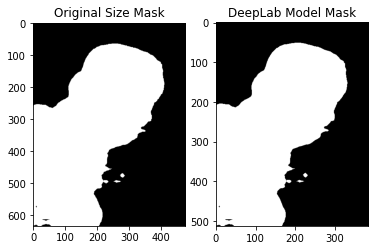

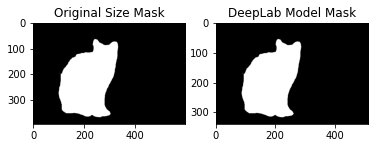

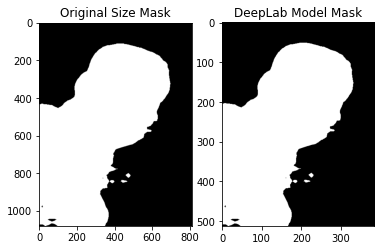

In [71]:
img_mask_ups = []
for i in range(len(img_origs)):
    img_mask_up = cv2.resize(img_masks[i], img_origs[i].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    img_mask_ups.append(img_mask_up)
    
    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_masks[i], cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

# 2. 배경준비

## 2-1. 배경 흐리게 하기

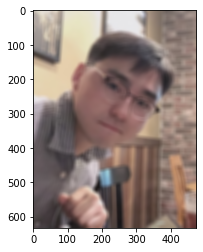

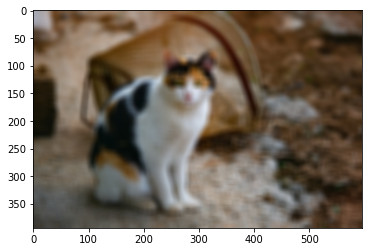

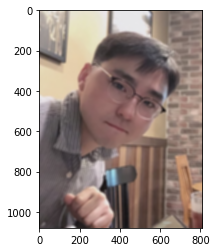

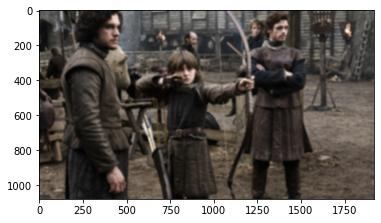

In [72]:
#기본 배경
img_orig_blurs = []
for img_orig in img_origs:
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    img_orig_blurs.append(img_orig_blur)
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

#합성용 배경
img_background_blur = cv2.blur(back_ground, (13, 13))
plt.imshow(cv2.cvtColor(img_background_blur, cv2.COLOR_BGR2RGB))
plt.show()

- [bitwise_not, bitwise_and 과 이미지](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)


## 2-2. 흐려진 배경과 1에서 구한 mask 합치기

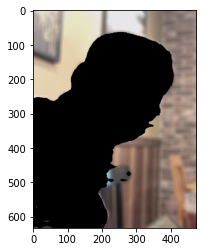

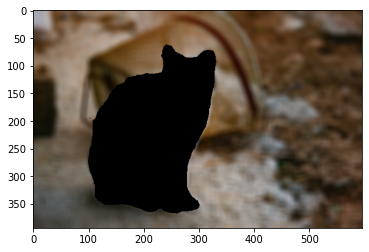

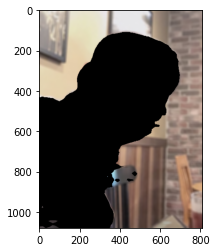

In [76]:
#필요: img_mask_up, img_orig_blur
img_mask_colors = []
img_bg_blurs = []
for i in range(len(img_mask_ups)):
    img_mask_color = cv2.cvtColor(img_mask_ups[i], cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blurs[i], img_bg_mask)
    img_mask_colors.append(img_mask_color)
    img_bg_blurs.append(img_bg_blur)
    plt.imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

# 3. 합성 
- [np.where( )](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

### 배경을 흐리게 처리해보자!
#### [① 인물사진과 ②고양이 사진]

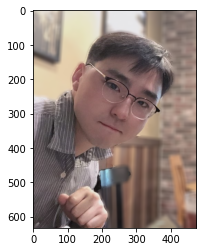

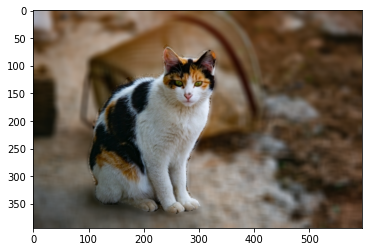

In [88]:
for i in range(len(img_origs[:-1])):
    img_concat = np.where(img_mask_colors[i]==255, img_origs[i], img_bg_blurs[i])
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    cv2.imwrite(os.path.join(img_dir,f'blurred_img_{i}.jpg'),img_concat)

### 왕좌의 게임 속 한 장면에 들어가보자!
#### [③ 배경전환 크로마키]

In [85]:
target_area = img_background_blur[:,:810,:]
img_background_blur[:, :810, :] = np.where(img_mask_colors[-1]==255, img_origs[-1], target_area)

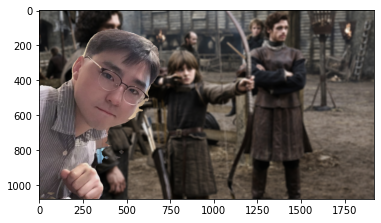

In [86]:
plt.imshow(cv2.cvtColor(img_background_blur, cv2.COLOR_BGR2RGB))
plt.show()

## [Part2] 문제점 식별

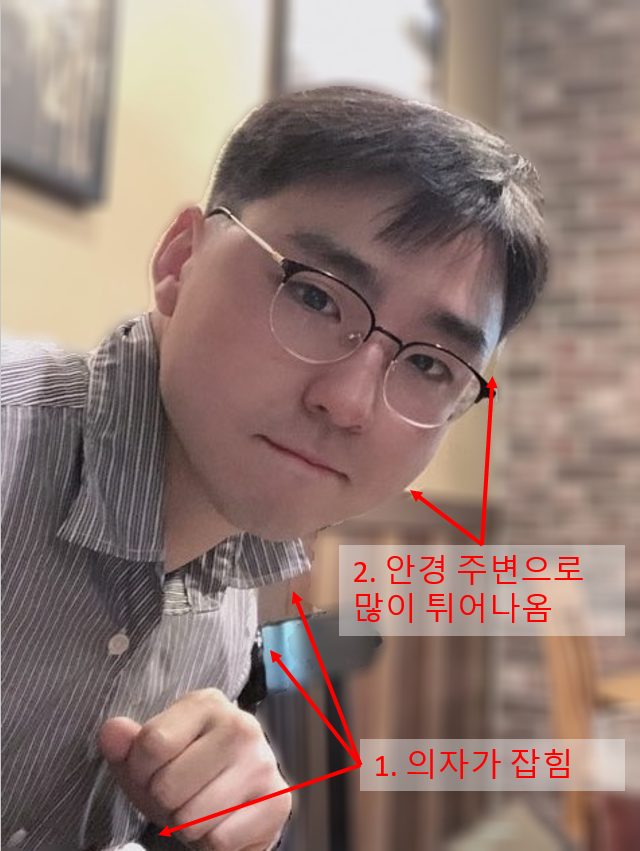

## [Part3] 문제점 해결
- Segmentation은 기본적으로 RGB값을 받아 심도를 추정하는 작업으로, 자연적인 한계를 지닌다. 그렇다면 어떻게 이러한 추정을 더 정확하게 만들 수 있을까 ? 노드에서 제안한 여러가지 방법중 **[struct2depth](https://sites.google.com/view/struct2depth)**를 살펴보기로 한다. [참고: 코드](https://github.com/tensorflow/models/tree/archive/research/struct2depth)
- 관련용어
  - ego-motion : 환경 내에서 카메라의 3차원 이동


 - Google Brain에 기재된 Unsupervised Learning of Depth and Ego-Motion: A Structured Approach논문은 하나의 카메라를 이용해 Dynamic환경에서 Depth Sensing과 Ego-Motion을 추정하는 기법에 대한 새로운 방법을 다루고 있다.
 
 - 해당 논문에서 Depth를 추정하기 위해서 depth function을 도입하고 있다.
   - $\theta : R^{HxWx3} → R^{HxW}$: fully convolutional encoder-decoder neural network
   - $D_i = \theta(I_i)$: 이 함수는 이미지를 입력하면 Depth Map을 출력하는 방식으로 작동한다 

- 실제로 적용 결과 Dynamic한 환경에서도 Depth를 ground truth와 거의 차이없이 추정하고 있음을 볼 수 있다!
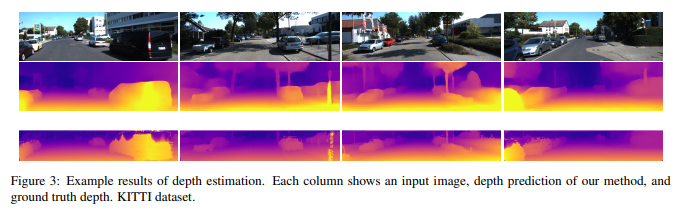
- 이전의 여타 모델들보다 낮은 오차를 보이는 것도 확인할 수 있다.
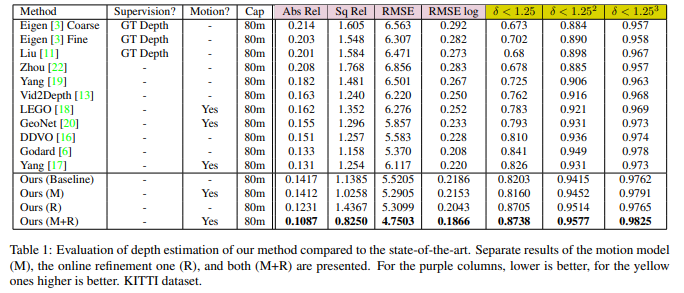

이처럼 struct2depth에서 제공하는 모델을 활용하면 주어진 RGB값에서 Depth를 적절히 출력하는 것이 가능하고, 그렇다면 어렵지 않게 shallow focus를 구현할 수 있을 것으로 기대된다.

# 회고
- cv와 새로운 논문은 언제나 어려운 주제이다.
- 논문을 읽고 구현할 수 있다면 주어진 문제를 해결하는 기쁨을 맞볼 수 있었을 것이지만, 아직 그 정도의 실력에 이르지는 못하였다.
- 이제 점점 보편적인 사고로 쓸 수 있는 코드를 넘어서는 노드들이 많다는 생각이 든다. 반면에 현장에서는 이와 같이 API나 새로운 모델을 사용하는 일이 많을 것이므로, 코드의 모든 면면을 이해하고 쓰는 것도 중요하지만, 새로운 코드를 적절히 활용하는 능력도 중요하다고 느꼈다.
- 루브릭 지표의 두 가지 과제는 단순히 코드를 따라 쓰는 것으로 달성할 수 있었으나, 구체적으로 코드 내부 함수들이 어떻게 동작하는지 이해하는데 모두 이해하지는 못했다. 아쉽지만 선택이 필요한 부분이라는 생각이 든다.
- 루브릭 지표의 세번째 과제는 주어진 방식들 중 하나를 선택해 적용하는 것이었는데, 큰 틀에 있어 이해하려고 노력하였고, 기회가 된다면 pytorch를 이용해 구현할 수 있는 실력을 길러보고 싶다는 마음이 들었다.